In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import collections
import torch
import mord as m
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import MiniBatchSparsePCA
from sklearn.kernel_approximation import RBFSampler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, GridSearchCV, StratifiedKFold, cross_val_score

In this notebook, supervised methods are implemented and evaluated using various dimensionality reduction techniques.

## Load processed data

In [2]:
train_data = pd.read_csv('train_data_processed.csv')
test_data = pd.read_csv('test_data_processed.csv')
train_labels = np.load('train_labels.csv.npy', allow_pickle=True)
test_labels = np.load('test_labels.csv.npy', allow_pickle=True)

In [3]:
# Explains more than 80% of the variance in the data
pca = PCA(n_components=100)
scaler = StandardScaler()

train_scaled = scaler.fit_transform(train_data)
pca_train_genes = pca.fit_transform(train_scaled)

test_scaled = scaler.transform(test_data)
pca_test_genes = pca.transform(test_scaled)

all_weights = pd.DataFrame(pca.components_)
all_weights.columns = train_data.columns.values

In [4]:
important_genes = []
for i in range(50):
    important_genes.append([pd.DataFrame(np.abs(all_weights)).T.nlargest(100, i).index.values])
important_genes = np.unique(important_genes, return_counts=False)

In [5]:
important_train = train_data[important_genes]
important_test = test_data[important_genes]

In [6]:
label_mapping = {'WHO II': 0, 'WHO III': 1, 'WHO IV': 2}
reverse_mapping = {0: 'WHO II', 1: 'WHO III', 2: 'WHO IV'}
mapped_labels_train = [label_mapping[x[0]] for x in train_labels]
mapped_labels_test = [label_mapping[x[0]] for x in test_labels]

# Visualize the important genes

In [0]:
def display_pca(input_data, labels, title):
    high_scaler = StandardScaler()
    input_scaled = high_scaler.fit_transform(input_data)
    
    pca = PCA(n_components=2)
    transformed_data = pca.fit_transform(input_scaled)
    
    data_df = pd.DataFrame(data = transformed_data, columns = ['principal component 1', 'principal component 2'])
    class_labels_df = pd.DataFrame(labels)
    data_df = pd.concat([data_df, class_labels_df], axis = 1)
    data_df.columns = ['PC1', 'PC2', 'Grade']
    
    fig = plt.figure(figsize = (20, 10))
    ax = fig.add_subplot(1,2,1) 
    ax.set_title(title, fontsize = 15)
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    targets = ['WHO II', 'WHO III', 'WHO IV']
    colors = ['r', 'g', 'b']
    for target, color in zip(targets,colors):
        indicesToKeep = data_df['Grade'] == target
        ax.scatter(data_df.loc[indicesToKeep, 'PC1']
                   , data_df.loc[indicesToKeep, 'PC2']
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()

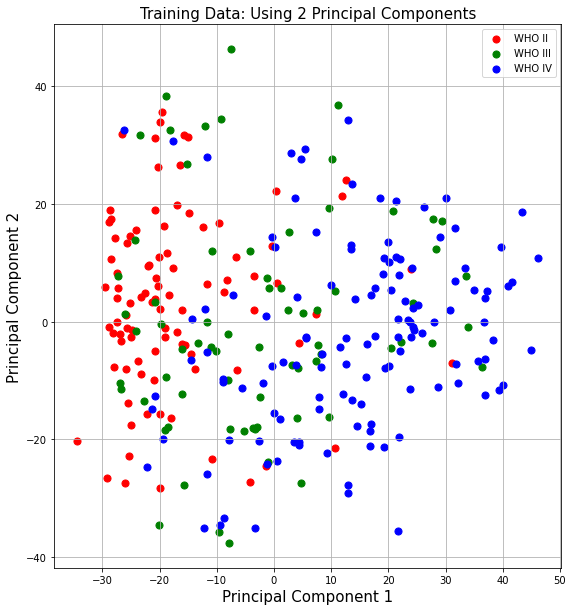

In [0]:
display_pca(important_train, train_labels, 'Training Data: Using 2 Principal Components')

## Standard Random Forest Classifier

In [0]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 15)]
max_depth = [int(x) for x in np.linspace(start = 3, stop = 20, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 1, stop = 50, num = 15)]
rf = RandomForestClassifier(bootstrap='True', random_state=0, max_features='auto')
cv_strategy = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

In [0]:
rf_params = {'n_estimators': n_estimators, 
             'max_depth': max_depth, 
             'min_samples_split': min_samples_split}

In [0]:
rf_random_search = RandomizedSearchCV(rf, rf_params, cv=cv_strategy, n_jobs=-1, return_train_score=True)

- Conducted on the 3000+ most important genes

In [0]:
rf_random_search.fit(important_train, mapped_labels_train)
rf_random_search.best_score_

0.688735632183908

In [0]:
rf_random_search.score(important_test, mapped_labels_test)

0.6666666666666666

- Conducted on the top 100 PCs

In [0]:
rf_random_search_pca = RandomizedSearchCV(rf, rf_params, cv=cv_strategy, n_jobs=-1, return_train_score=True)
rf_random_search_pca.fit(pca_train_genes, mapped_labels_train)
rf_random_search_pca.best_score_

0.661264367816092

In [0]:
rf_random_search_pca.score(pca_test_genes, mapped_labels_test)

0.696969696969697

# Kernel SVM

In [7]:
important_train_scaled = scaler.fit_transform(important_train)
important_test_scaled = scaler.transform(important_test)

- Using 3000+ genes

In [0]:
cv_strategy = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C': np.logspace(-3, 3, 7), 'gamma': ('auto', 'scale')}
svc_grid = GridSearchCV(SVC(), parameters, cv=cv_strategy, n_jobs=-1, return_train_score=True)
svc_grid.fit(important_train_scaled, mapped_labels_train)
svc_grid.best_score_

0.6855172413793104

In [0]:
svc_grid.score(important_test_scaled, mapped_labels_test)

0.696969696969697

- Using top 100 PCs

In [0]:
cv_strategy = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C': np.logspace(-3, 3, 7), 'gamma': ('auto', 'scale')}
svc_grid = GridSearchCV(SVC(), parameters, cv=cv_strategy, n_jobs=-1, return_train_score=True)
svc_grid.fit(pca_train_genes, mapped_labels_train)
svc_grid.best_score_

0.689080459770115

In [0]:
svc_grid.score(pca_test_genes, mapped_labels_test)

0.696969696969697

## Considering the inherent order present in the classes

## Ordinal Logistic Regression
- AKA ordinal regression
- Predict a value which is ordered and also discrete 
- Seen as a generalization to binary logistic regresion
- Relies on correlated genes being removed
- Multinomial regression doesnt preserve the inherent ranking

- Using 3000 most important genes

In [0]:
c = m.LogisticIT()
cv_strategy = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
param_grid = {'alpha': np.logspace(-3,3,7)}
ridge_grid = GridSearchCV(c, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
ridge_grid.fit(np.array(important_train_scaled), np.array(mapped_labels_train))
ridge_grid.best_score_

0.6920689655172414

In [0]:
ridge_grid.score(np.array(important_test_scaled), np.array(mapped_labels_test))

0.7272727272727273

- Using top 100 PCs

In [0]:
c = m.LogisticIT()
cv_strategy = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
param_grid = {'alpha': np.logspace(-3,3,7)}
ridge_grid_pc = GridSearchCV(c, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
ridge_grid_pc.fit(np.array(pca_train_genes), np.array(mapped_labels_train))
ridge_grid_pc.best_score_

0.69183908045977

In [0]:
ridge_grid_pc.score(np.array(pca_test_genes), np.array(mapped_labels_test))

0.7878787878787878

# Small Neural Network
- Combine the two priors together: ordinal classes and overlapping
- http://orca.st.usm.edu/~zwang/files/rank.pdf

In [19]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [20]:
def convert_labels(inputs):
    converted = np.zeros((len(inputs), 3))
    for i in range(len(inputs)):
        current_val = inputs[i]
        if current_val == 1:
            converted[i][1] = 1
            converted[i][0] = 1
        elif current_val == 2:
            converted[i][0] = 1
            converted[i][1] = 1
            converted[i][2] = 1
        else:
            converted[i][0] = 1
    return converted

In [21]:
# Convert target variables 
converted_train = convert_labels(mapped_labels_train)
converted_test = convert_labels(mapped_labels_test)

In [22]:
# Convert to tensors
# First only use the PCs
train_tensor = torch.tensor(pca_train_genes.astype(np.float32)) 
test_tensor = torch.tensor(pca_test_genes.astype(np.float32))
train_target_tensor = torch.tensor(converted_train)
test_target_tensor = torch.tensor(converted_test)

In [62]:
#batch_size = 16
# Define datasets and dataloaders
testing_dataset = TensorDataset(test_tensor, test_target_tensor)
training_dataset = TensorDataset(train_tensor, train_target_tensor)
test_dataloader = DataLoader(testing_dataset, batch_size = 1)
train_dataloader = DataLoader(training_dataset, batch_size = 1)

In [24]:
class EntropyLoss(torch.nn.Module):
    def __init__(self):
        super(EntropyLoss, self).__init__()

    def forward(self, model_output, target):
        bc1 = torch.nn.functional.binary_cross_entropy(model_output[:,0], target[:,0])
        bc2 = torch.nn.functional.binary_cross_entropy(model_output[:,1], target[:,1])
        bc3 = torch.nn.functional.binary_cross_entropy(model_output[:,2], target[:,2])
        return bc1 + bc2 + bc3

In [25]:
# Define loss function
# loss_function = torch.nn.NLLLoss()
loss_function = EntropyLoss()
device = torch.device('cuda:0')

In [26]:
class rnn_model(torch.nn.Module):
    def __init__(self):
        super(rnn_model, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(100, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 3),
            # Sigmoid funtion on each of the output nodes
            torch.nn.Sigmoid()
        )

    # The last layer hidden states from BERT are used as embeddings/semantic 
    # representation for the input and therefore, passed into the MLP
    def forward(self, x):
        out = self.layers(x)
        return out

In [43]:
# Compile and train model
model = rnn_model()
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5, eps = 1e-8)

In [48]:
epochs = 300
for e in range(0, epochs):
    model.train()
    current_loss = 0
    for i, (X, y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        # To GPU
        X = X.to(device)
        y = y.to(device).double()
        output = model(X).double()
        loss = loss_function(output, y)
        loss = loss.type(torch.cuda.FloatTensor)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()
        torch.cuda.empty_cache()
    print(f'Epoch: {e+1}, Loss: {current_loss/len(train_dataloader)}')

Epoch: 1, Loss: 0.6170555957053837
Epoch: 2, Loss: 0.615812256147987
Epoch: 3, Loss: 0.6145724418916201
Epoch: 4, Loss: 0.6133382689011725
Epoch: 5, Loss: 0.6121119190203516
Epoch: 6, Loss: 0.6108848123173964
Epoch: 7, Loss: 0.6096662714293128
Epoch: 8, Loss: 0.6084513499548561
Epoch: 9, Loss: 0.607242265814229
Epoch: 10, Loss: 0.606036796381599
Epoch: 11, Loss: 0.6048302470069182
Epoch: 12, Loss: 0.6036319450328225
Epoch: 13, Loss: 0.602437602846246
Epoch: 14, Loss: 0.6012493599402277
Epoch: 15, Loss: 0.6000650250598004
Epoch: 16, Loss: 0.5988917201757431
Epoch: 17, Loss: 0.5977129630352321
Epoch: 18, Loss: 0.5965410721929449
Epoch: 19, Loss: 0.5953754006247771
Epoch: 20, Loss: 0.5942105674429944
Epoch: 21, Loss: 0.5930521739156622
Epoch: 22, Loss: 0.5918939717506108
Epoch: 23, Loss: 0.5907424727552816
Epoch: 24, Loss: 0.589592990906615
Epoch: 25, Loss: 0.5884463630224529
Epoch: 26, Loss: 0.5873086828934518
Epoch: 27, Loss: 0.5861727838453493
Epoch: 28, Loss: 0.5850465195743662
Epoch:

Epoch: 226, Loss: 0.40043556102012334
Epoch: 227, Loss: 0.3996558863865702
Epoch: 228, Loss: 0.3988671804729261
Epoch: 229, Loss: 0.3980836366352282
Epoch: 230, Loss: 0.3973056164227034
Epoch: 231, Loss: 0.3965231525270562
Epoch: 232, Loss: 0.3957536549944627
Epoch: 233, Loss: 0.3949756430167901
Epoch: 234, Loss: 0.39420585530368907
Epoch: 235, Loss: 0.3934297604780448
Epoch: 236, Loss: 0.3926613636707005
Epoch: 237, Loss: 0.39188791968320547
Epoch: 238, Loss: 0.39112074124185664
Epoch: 239, Loss: 0.3903519746504332
Epoch: 240, Loss: 0.38958424604252767
Epoch: 241, Loss: 0.3888169542739266
Epoch: 242, Loss: 0.388061475204794
Epoch: 243, Loss: 0.38730000586886154
Epoch: 244, Loss: 0.38654087797591563
Epoch: 245, Loss: 0.38578100659345327
Epoch: 246, Loss: 0.38502421426145655
Epoch: 247, Loss: 0.38427032255812693
Epoch: 248, Loss: 0.3835099237529855
Epoch: 249, Loss: 0.38275875268798126
Epoch: 250, Loss: 0.3820089705680546
Epoch: 251, Loss: 0.38125526316856084
Epoch: 252, Loss: 0.3805059

In [49]:
test_outputs = []
for i, (X, y) in enumerate(test_dataloader):
    optimizer.zero_grad()
    X = X.to(device)
    output = model(X)   
    test_outputs.append(output.cpu().detach().numpy())

In [50]:
test_outputs_converted = []
for i in range(len(test_outputs)):
    current = test_outputs[i][0]
    add = [1 if x >= 0.50 else 0 for x in current]
    test_outputs_converted.append(add)
test_outputs_converted = np.array(test_outputs_converted)

In [52]:
test_outputs_labels = []
for label in test_outputs_converted:
    if label[0] == 1 and label[1] == 1 and label[2] == 1:
        test_outputs_labels.append('WHO IV')
    elif label[0] == 1 and label[1] == 1:
        test_outputs_labels.append('WHO III')
    else:
        test_outputs_labels.append('WHO II')

In [51]:
accuracy = 0
missed = []
for i in range(len(test_outputs_converted)):
    if collections.Counter(test_outputs_converted[i]) == collections.Counter(converted_test[i]):
        accuracy += 1
    else:
        missed.append(i)
print(f'Testing Accuracy: {accuracy/33}')

Testing Accuracy: 0.8181818181818182


# Plot the labels given to the training and testing data by MLP

In [63]:
train_outputs = []
for i, (X, y) in enumerate(train_dataloader):
    optimizer.zero_grad()
    X = X.to(device)
    output = model(X)   
    train_outputs.append(output.cpu().detach().numpy())

In [65]:
train_outputs_converted = []
for i in range(len(train_outputs)):
    current = train_outputs[i][0]
    add = [1 if x >= 0.50 else 0 for x in current]
    train_outputs_converted.append(add)
train_outputs_converted = np.array(train_outputs_converted)

In [66]:
train_output_labels = []
for label in train_outputs_converted:
    if label[0] == 1 and label[1] == 1 and label[2] == 1:
        train_output_labels.append('WHO IV')
    elif label[0] == 1 and label[1] == 1:
        train_output_labels.append('WHO III')
    else:
        train_output_labels.append('WHO II')

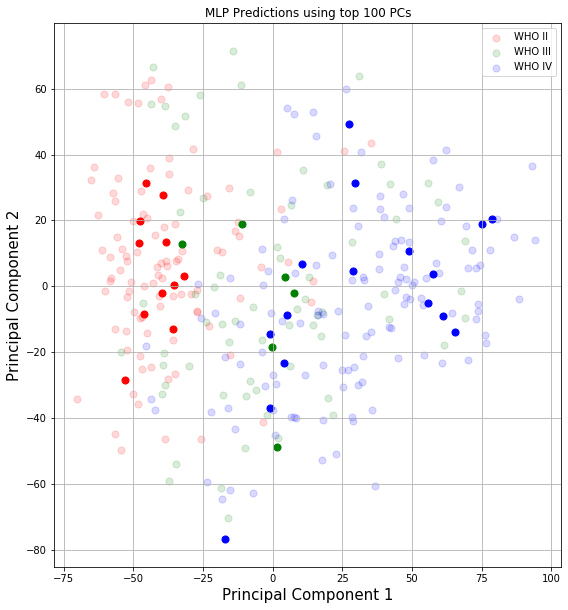

In [70]:
pca = PCA(n_components=2)
high_scaler = StandardScaler()
train_scaled = high_scaler.fit_transform(train_data)
test_scaled = high_scaler.transform(test_data)
transformed_data = pca.fit_transform(train_scaled)
transformed_data_test = pca.transform(test_scaled)
training_plot = pd.DataFrame(data = transformed_data, columns = ['principal component 1', 'principal component 2'])
testing_plot = pd.DataFrame(data = transformed_data_test, columns = ['principal component 1', 'principal component 2'])
class_labels_df_train = pd.DataFrame(train_output_labels)
class_labels_df_test = pd.DataFrame(test_outputs_labels)
training_df = pd.concat([training_plot, class_labels_df_train], axis = 1)
training_df.columns = ['PC1', 'PC2', 'Grade']
testing_df = pd.concat([testing_plot, class_labels_df_test], axis = 1)
testing_df.columns = ['PC1', 'PC2', 'Grade'] 
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(1,2,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
targets = ['WHO II', 'WHO III', 'WHO IV']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = training_df['Grade'] == target
    ax.scatter(training_df.loc[indicesToKeep, 'PC1']
               , training_df.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50, alpha = 0.15)
for target, color in zip(targets,colors):
    indicesToKeep = testing_df['Grade'] == target
    ax.scatter(testing_df.loc[indicesToKeep, 'PC1']
               , testing_df.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.set_title('MLP Predictions using top 100 PCs')
ax.grid()

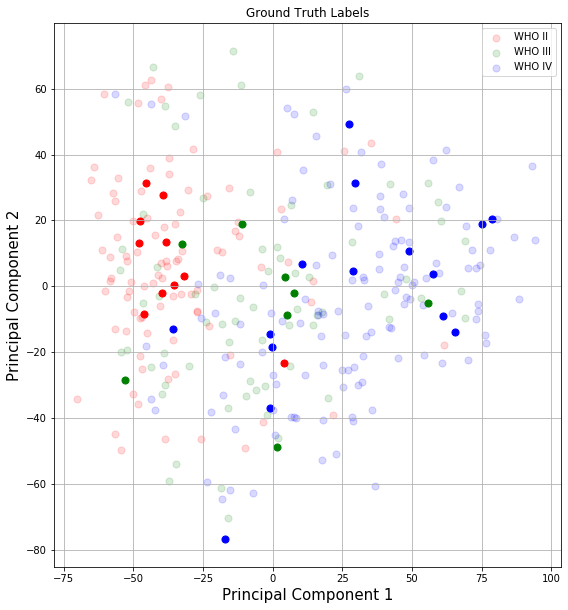

In [72]:
# Ground Truth
pca = PCA(n_components=2)
high_scaler = StandardScaler()
train_scaled = high_scaler.fit_transform(train_data)
test_scaled = high_scaler.transform(test_data)
transformed_data = pca.fit_transform(train_scaled)
transformed_data_test = pca.transform(test_scaled)
training_plot = pd.DataFrame(data = transformed_data, columns = ['principal component 1', 'principal component 2'])
testing_plot = pd.DataFrame(data = transformed_data_test, columns = ['principal component 1', 'principal component 2'])
class_labels_df_train = pd.DataFrame(train_labels)
class_labels_df_test = pd.DataFrame(test_labels)
training_df = pd.concat([training_plot, class_labels_df_train], axis = 1)
training_df.columns = ['PC1', 'PC2', 'Grade']
testing_df = pd.concat([testing_plot, class_labels_df_test], axis = 1)
testing_df.columns = ['PC1', 'PC2', 'Grade'] 
fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(1,2,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
targets = ['WHO II', 'WHO III', 'WHO IV']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = training_df['Grade'] == target
    ax.scatter(training_df.loc[indicesToKeep, 'PC1']
               , training_df.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50, alpha = 0.15)
for target, color in zip(targets,colors):
    indicesToKeep = testing_df['Grade'] == target
    ax.scatter(testing_df.loc[indicesToKeep, 'PC1']
               , testing_df.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.set_title('Ground Truth Labels')
ax.legend(targets)
ax.grid()

# Feature Analysis on the top performing models

In [20]:
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE

# Permutation Importance

In [25]:
# permutation importance
pi = permutation_importance(ridge_grid_pc.best_estimator_, pca_train_genes, mapped_labels_train, n_repeats=10, random_state=0)
pi_mean_vals = pi['importances_mean']
cols = pd.DataFrame(pca_train_genes).columns
pi_importances_pairs = zip(cols, pi_mean_vals)
pi_pairs_sorted = sorted(pi_importances_pairs, key=lambda x: x[1], reverse=True)

In [26]:
# Get all the non-zero importance genes
non_zero_pi = [x[0] for x in pi_pairs_sorted if x[1] > 0]

# Recursive Feature Elimination

In [27]:
#rfe
selector = RFE(ridge_grid_pc.best_estimator_, 1, step=1)
selector = selector.fit(pca_train_genes, mapped_labels_train)
ranking_pairs = zip(pd.DataFrame(pca_train_genes).columns, selector.ranking_)
ranking_pairs_sorted = sorted(ranking_pairs, key=lambda x: x[1])

In [28]:
top_100_rfe = []
for i in range(100):
    top_100_rfe.append(ranking_pairs_sorted[i][0])

# Exploring other feature selection/reduction techniques

# Sparse PCA: PCA with L1 Regularization

In [14]:
n = 2
sparse_pca = MiniBatchSparsePCA(n_components = n).fit(train_scaled)
sparse_train_genes = sparse_pca.transform(train_scaled)
sparse_test_genes = sparse_pca.transform(test_scaled)

# Ordinal Regression on Sparse PCA

In [0]:
c = m.LogisticIT()
cv_strategy = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
param_grid = {'alpha': np.logspace(-3,3,7)}
ridge_grid = GridSearchCV(c, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
ridge_grid.fit(np.array(sparse_train_genes), np.array(mapped_labels_train))
ridge_grid.best_score_

0.6578160919540229

In [0]:
ridge_grid.score(np.array(sparse_test_genes), np.array(mapped_labels_test))

0.696969696969697

# Kernel SVM on Sparse PCA

In [17]:
cv_strategy = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
parameters = {'kernel':('linear', 'rbf'), 'C': np.logspace(-3, 3, 4)}
svc_grid = GridSearchCV(SVC(), parameters, cv=cv_strategy, n_jobs=-1, return_train_score=True)
svc_grid.fit(np.array(sparse_train_genes), np.array(mapped_labels_train))
svc_grid.best_score_

0.661264367816092

In [18]:
svc_grid.score(np.array(sparse_test_genes), np.array(mapped_labels_test))

0.696969696969697

# Neural Network for sparse PCA

In [0]:
train_target_tensor = torch.tensor(converted_train)
test_target_tensor = torch.tensor(converted_test)

In [0]:
train_tensor = torch.tensor(sparse_important_train.values.astype(np.float32)) 
test_tensor = torch.tensor(sparse_important_test.values.astype(np.float32))
batch_size = 16
# Define datasets and dataloaders
testing_dataset = TensorDataset(test_tensor, test_target_tensor)
training_dataset = TensorDataset(train_tensor, train_target_tensor)
test_dataloader = DataLoader(testing_dataset, batch_size = 1)
train_dataloader = DataLoader(training_dataset, batch_size = batch_size )

In [0]:
class rnn_model(torch.nn.Module):
    def __init__(self):
        super(rnn_model, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(len(sparse_important_train.columns), 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 3),
            # Sigmoid funtion on each of the output nodes
            torch.nn.Sigmoid()
        )

    # The last layer hidden states from BERT are used as embeddings/semantic 
    # representation for the input and therefore, passed into the MLP
    def forward(self, x):
        out = self.layers(x)
        return out

In [0]:
# Compile and train model
model = rnn_model()
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5, eps = 1e-8)

In [0]:
epochs = 500
for e in range(0, epochs):
    model.train()
    current_loss = 0
    for i, (X, y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        # To GPU
        X = X.to(device)
        y = y.to(device).double()
        output = model(X).double()
        loss = loss_function(output, y)
        loss = loss.type(torch.cuda.FloatTensor)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()
        torch.cuda.empty_cache()
    print(f'Epoch: {e+1}, Loss: {current_loss/len(train_dataloader)}')

Epoch: 1, Loss: 2.085032394057826
Epoch: 2, Loss: 2.0490491954903853
Epoch: 3, Loss: 2.0117379803406563
Epoch: 4, Loss: 1.9732023979488171
Epoch: 5, Loss: 1.934707854923449
Epoch: 6, Loss: 1.8973391495252911
Epoch: 7, Loss: 1.8607337412081266
Epoch: 8, Loss: 1.8239907277257819
Epoch: 9, Loss: 1.7876568279768292
Epoch: 10, Loss: 1.7524298366747404
Epoch: 11, Loss: 1.7185349025224383
Epoch: 12, Loss: 1.6869918296211643
Epoch: 13, Loss: 1.6579956631911428
Epoch: 14, Loss: 1.6310610582954006
Epoch: 15, Loss: 1.6061146886725175
Epoch: 16, Loss: 1.5831599110051204
Epoch: 17, Loss: 1.5619800467240184
Epoch: 18, Loss: 1.5422855050940263
Epoch: 19, Loss: 1.5239977334675037
Epoch: 20, Loss: 1.5069608249162372
Epoch: 21, Loss: 1.4910249647341276
Epoch: 22, Loss: 1.4760495737979287
Epoch: 23, Loss: 1.461932383085552
Epoch: 24, Loss: 1.4485766887664795
Epoch: 25, Loss: 1.4359307791057385
Epoch: 26, Loss: 1.4238866693095158
Epoch: 27, Loss: 1.4124288182509572
Epoch: 28, Loss: 1.4016022180256091
Epoc

In [0]:
test_outputs = []
for i, (X, y) in enumerate(test_dataloader):
    optimizer.zero_grad()
    X = X.to(device)
    output = model(X)   
    test_outputs.append(output.cpu().detach().numpy())

In [0]:
test_outputs_converted = []
for i in range(len(test_outputs)):
    current = test_outputs[i][0]
    add = [1 if x >= 0.50 else 0 for x in current]
    test_outputs_converted.append(add)
test_outputs_converted = np.array(test_outputs_converted)

In [0]:
accuracy = 0
missed = []
for i in range(len(test_outputs_converted)):
    if collections.Counter(test_outputs_converted[i]) == collections.Counter(converted_test[i]):
        accuracy += 1
    else:
        missed.append(i)
print(f'Testing Accuracy: {accuracy/33}')

Testing Accuracy: 0.7272727272727273


# Factor Analysis

In [8]:
from sklearn.decomposition import FactorAnalysis

In [9]:
factors = FactorAnalysis(n_components = 100, copy = True, random_state = 15)
fa_train_genes = factors.fit_transform(train_data)
fa_test_genes = factors.transform(test_data)

In [10]:
all_weights = pd.DataFrame(factors.components_)
col_names = train_data.columns.values
all_weights.columns = col_names

In [11]:
fa_important_genes = []
temp = pd.DataFrame(np.abs(all_weights)).T
for i in range(50):
    fa_important_genes.extend(temp.nlargest(100, i).index.values)
fa_important_genes = np.unique(fa_important_genes)
fa_important_train = train_data[fa_important_genes]
fa_important_test = test_data[fa_important_genes]

# Ordinal Regression using FA

In [0]:
c = m.LogisticIT()
cv_strategy = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
param_grid = {'alpha': np.logspace(-3,3,7)}
ridge_grid_fa = GridSearchCV(c, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
ridge_grid_fa.fit(np.array(fa_important_train), np.array(mapped_labels_train))
ridge_grid_fa.best_score_

0.6854022988505747

In [0]:
ridge_grid_fa.score(np.array(fa_important_test), np.array(mapped_labels_test))

0.7272727272727273

# Kernel SVM using FA

In [12]:
cv_strategy = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C': np.logspace(-3, 3, 7), 'gamma': ('auto', 'scale')}
svc_grid = GridSearchCV(SVC(), parameters, cv=cv_strategy, n_jobs=-1, return_train_score=True)
svc_grid.fit(np.array(fa_important_train), np.array(mapped_labels_train))
svc_grid.best_score_

0.685287356321839

In [13]:
svc_grid.score(np.array(fa_important_test), np.array(mapped_labels_test))

0.696969696969697

# Retrain Neural Network using FA

In [0]:
train_tensor = torch.tensor(fa_important_train.values.astype(np.float32)) 
test_tensor = torch.tensor(fa_important_test.values.astype(np.float32))
batch_size = 16
# Define datasets and dataloaders
testing_dataset = TensorDataset(test_tensor, test_target_tensor)
training_dataset = TensorDataset(train_tensor, train_target_tensor)
test_dataloader = DataLoader(testing_dataset, batch_size = 1)
train_dataloader = DataLoader(training_dataset, batch_size = batch_size )

In [0]:
class rnn_model(torch.nn.Module):
    def __init__(self):
        super(rnn_model, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(len(fa_important_train.columns), 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 3),
            # Sigmoid funtion on each of the output nodes
            torch.nn.Sigmoid()
        )

    # The last layer hidden states from BERT are used as embeddings/semantic 
    # representation for the input and therefore, passed into the MLP
    def forward(self, x):
        out = self.layers(x)
        return out

In [0]:
# Compile and train model
model = rnn_model()
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5, eps = 1e-8)

In [0]:
epochs = 500
for e in range(0, epochs):
    model.train()
    current_loss = 0
    for i, (X, y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        # To GPU
        X = X.to(device)
        y = y.to(device).double()
        output = model(X).double()
        loss = loss_function(output, y)
        loss = loss.type(torch.cuda.FloatTensor)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()
        torch.cuda.empty_cache()
    print(f'Epoch: {e+1}, Loss: {current_loss/len(train_dataloader)}')

Epoch: 1, Loss: 2.125166052266171
Epoch: 2, Loss: 2.007887695965014
Epoch: 3, Loss: 1.9084436830721403
Epoch: 4, Loss: 1.814291194865578
Epoch: 5, Loss: 1.7224170659717761
Epoch: 6, Loss: 1.6308397682089555
Epoch: 7, Loss: 1.5438754746788426
Epoch: 8, Loss: 1.4668110483571102
Epoch: 9, Loss: 1.4009725294615094
Epoch: 10, Loss: 1.3448578558470075
Epoch: 11, Loss: 1.2968745106144954
Epoch: 12, Loss: 1.2551636758603548
Epoch: 13, Loss: 1.2179283091896458
Epoch: 14, Loss: 1.1844127178192139
Epoch: 15, Loss: 1.1540375728356211
Epoch: 16, Loss: 1.1260926378400702
Epoch: 17, Loss: 1.1002675451730426
Epoch: 18, Loss: 1.0763151300580878
Epoch: 19, Loss: 1.0541409128590633
Epoch: 20, Loss: 1.0337836961997182
Epoch: 21, Loss: 1.0149140546196385
Epoch: 22, Loss: 0.9974033832550049
Epoch: 23, Loss: 0.9810020233455458
Epoch: 24, Loss: 0.9656160567936144
Epoch: 25, Loss: 0.9512904631464105
Epoch: 26, Loss: 0.93794668348212
Epoch: 27, Loss: 0.9254364590895804
Epoch: 28, Loss: 0.9136322987707037
Epoch:

In [0]:
test_outputs = []
for i, (X, y) in enumerate(test_dataloader):
    optimizer.zero_grad()
    X = X.to(device)
    output = model(X)   
    test_outputs.append(output.cpu().detach().numpy())
test_outputs_converted = []
for i in range(len(test_outputs)):
    current = test_outputs[i][0]
    add = [1 if x >= 0.50 else 0 for x in current]
    test_outputs_converted.append(add)
test_outputs_converted = np.array(test_outputs_converted)

In [0]:
accuracy = 0
missed = []
for i in range(len(test_outputs_converted)):
    if collections.Counter(test_outputs_converted[i]) == collections.Counter(converted_test[i]):
        accuracy += 1
    else:
        missed.append(i)
print(f'Testing Accuracy: {accuracy/33}')

Testing Accuracy: 0.7272727272727273


# Which genes did the supervised methods identify as the most important?

In [32]:
original_data = pd.read_csv('data/study_1/expression_data.csv')

In [34]:
all_gene_names = list(original_data['Gene_Name'])
genes_selected = [all_gene_names[int(x)] for x in train_data.columns]

In [29]:
common_components = []
for i in non_zero_pi:
    if i in top_100_rfe:
        common_components.append(i)

In [40]:
common_pca = pd.DataFrame(pca.components_).iloc[common_components]
important_supervised_genes = []
for i in range(len(common_components)):
    important_supervised_genes.append([pd.DataFrame(np.abs(common_pca)).T.nlargest(1, common_components[i]).index.values])
important_supervised_genes = np.unique(important_supervised_genes, return_counts=False)

In [41]:
for i in important_supervised_genes:
    print(genes_selected[i])

AC007551.3
AC009950.2
APOC1P1
ARL4A
ARL4D
C5orf63
CA8
CABP7
CASP4
CDC42EP4
CES4A
CIB2
CRYBB2P1
CTA-253N17.1
CTU1
DDX11L2
DHX40P1
ETNK2
FKBP5
GPR146
GS1-259H13.2
GSTT2B
IFI27
IGLV5-52
KANSL1L
KDM5D
LA16c-380A1.1
LECT1
MEIS2
MT-ATP8
MYO5BP2
NDRG1
NOS2
NR4A1
NRG1
NSUN5P2
NXN
OSBP2
PCDHGA9
PIK3C2B
PIPOX
PLXNA4
RNF207
RNVU1-7
RP1-37N7.3
RP11-108M9.4
RP11-108P20.1
RP11-222A11.1
RP11-329B9.5
RP11-395G23.3
RP11-3B12.1
RP11-449P15.2
RP11-488L18.10
RP11-572P18.1
RP11-672L10.6
RP11-730A19.9
RP11-797A18.6
RP11-844P9.2
RP11-967K21.1
RP11-96H19.1
RP11-977G19.12
RP3-430N8.10
RP4-669L17.8
RP4-734P14.4
RP4-781K5.2
RPL36A-HNRNPH2
RPPH1
RPS17L
RPSAP41
SBF2-AS1
SETD9
SHC4
SLC38A11
SLC4A11
SLIT2
SNORA59B
SNORD17
SPCS2P4
SVEP1
TAF4B
TECRP1
TLE1
TNKS2-AS1
TOLLIP-AS1
TXLNG2P
ZBTB16
ZFY
ZNF229
ZNF469
